<a href="https://colab.research.google.com/github/bj-bestjung/Onjira-Portfolio/blob/main/US_Stock_Data_ETL_Pipeline_by_Python_and_SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy sqlite3 sqlalchemy yfinance matplotlib seaborn requests

ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3


# Import Library

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import yfinance as yf
from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

In [ ]:
class StockETLPipeline:
    def __init__(self, db_path='stock_data.db'):
        self.db_path = db_path
        self.setup_database()

    def setup_database(self):
        """สร้างฐานข้อมูลและตาราง"""
        conn = sqlite3.connect(self.db_path)
        cursor = conn.cursor()

        # ลบตารางเก่าถ้ามี
        cursor.execute('DROP TABLE IF EXISTS stock_data')

        # สร้างตารางใหม่
        cursor.execute('''
            CREATE TABLE stock_data (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                Date DATE,
                Open REAL,
                High REAL,
                Low REAL,
                Close REAL,
                Volume INTEGER,
                Symbol TEXT,
                MA_7 REAL,
                MA_30 REAL,
                MA_90 REAL,
                Daily_Return REAL,
                Volatility REAL,
                Price_Change REAL,
                Price_Change_Pct REAL,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
            )
        ''')

        # สร้าง Index เพื่อเพิ่มประสิทธิภาพ
        cursor.execute('CREATE INDEX idx_symbol_date ON stock_data(Symbol, Date)')
        cursor.execute('CREATE INDEX idx_date ON stock_data(Date)')
        cursor.execute('CREATE INDEX idx_symbol ON stock_data(Symbol)')

        conn.commit()
        conn.close()
        print("✅ Database setup เสร็จสิ้น")

    def extract_stock_data(self, symbols, period="1y"):
        """Extract: ดึงข้อมูลหุ้นจาก Yahoo Finance"""
        print("🔄 กำลังดึงข้อมูลหุ้น...")
        stock_data = {}
        successful = []
        failed = []

        for symbol in symbols:
            try:
                print(f"   กำลังดึงข้อมูล {symbol}...")
                ticker = yf.Ticker(symbol)
                data = ticker.history(period=period)

                if len(data) == 0:
                    print(f"   ⚠️  ไม่มีข้อมูลสำหรับ {symbol}")
                    failed.append(symbol)
                else:
                    data['Symbol'] = symbol
                    stock_data[symbol] = data
                    successful.append(symbol)
                    print(f"   ✅ ดึงข้อมูล {symbol} สำเร็จ: {len(data)} วัน")

            except Exception as e:
                print(f"   ❌ Error สำหรับ {symbol}: {str(e)}")
                failed.append(symbol)

        print(f"\n📊 สรุปการดึงข้อมูล:")
        print(f"   ✅ สำเร็จ: {len(successful)} หุ้น {successful}")
        if failed:
            print(f"   ❌ ล้มเหลว: {len(failed)} หุ้น {failed}")

        return stock_data

    def transform_data(self, stock_data):
        """Transform: แปลงข้อมูลและคำนวณ Technical Indicators"""
        print("\n🔄 กำลังแปลงข้อมูลและคำนวณ Technical Indicators...")
        transformed_data = []

        for symbol, df in stock_data.items():
            print(f"   🔄 กำลังประมวลผล {symbol}...")

            # Reset index เพื่อให้ Date เป็น column
            df = df.reset_index()

            # ตรวจสอบและแปลงชนิดข้อมูล
            df['Date'] = pd.to_datetime(df['Date'])

            # คำนวณ Moving Averages
            df['MA_7'] = df['Close'].rolling(window=7, min_periods=1).mean()
            df['MA_30'] = df['Close'].rolling(window=30, min_periods=1).mean()
            df['MA_90'] = df['Close'].rolling(window=90, min_periods=1).mean()

            # คำนวณ Daily Return (%)
            df['Daily_Return'] = df['Close'].pct_change() * 100

            # คำนวณ Volatility (30-day rolling standard deviation)
            df['Volatility'] = df['Daily_Return'].rolling(window=30, min_periods=1).std()

            # คำนวณ Price Change
            df['Price_Change'] = df['Close'] - df['Open']
            df['Price_Change_Pct'] = (df['Price_Change'] / df['Open']) * 100

            # ทำความสะอาดข้อมูล - เก็บเฉพาะ row ที่มีข้อมูลครบถ้วน
            df = df.dropna(subset=['Close', 'Open', 'High', 'Low', 'Volume'])

            # เพิ่มข้อมูลสถิติเพิ่มเติม
            df['High_Low_Pct'] = ((df['High'] - df['Low']) / df['Low']) * 100
            df['Close_vs_MA30'] = ((df['Close'] - df['MA_30']) / df['MA_30']) * 100

            transformed_data.append(df)
            print(f"   ✅ ประมวลผล {symbol} เสร็จสิ้น: {len(df)} rows")

        # รวมข้อมูลทั้งหมด
        if transformed_data:
            final_df = pd.concat(transformed_data, ignore_index=True)
            final_df = final_df.sort_values(['Symbol', 'Date']).reset_index(drop=True)
            print(f"\n✅ รวมข้อมูลเสร็จสิ้น: {len(final_df)} rows จาก {len(transformed_data)} หุ้น")
            return final_df
        else:
            print("❌ ไม่มีข้อมูลที่แปลงได้")
            return pd.DataFrame()

    def load_data(self, df):
        """Load: โหลดข้อมูลเข้า SQLite Database"""
        if df.empty:
            print("❌ ไม่มีข้อมูลที่จะโหลด")
            return

        print("\n🔄 กำลังโหลดข้อมูลเข้าฐานข้อมูล...")

        try:
            conn = sqlite3.connect(self.db_path)

            # โหลดข้อมูลเข้าตาราง
            df.to_sql('stock_data', conn, if_exists='replace', index=False)

            # ตรวจสอบจำนวนข้อมูลที่โหลด
            cursor = conn.cursor()
            cursor.execute("SELECT COUNT(*) FROM stock_data")
            count = cursor.fetchone()[0]

            cursor.execute("SELECT COUNT(DISTINCT Symbol) FROM stock_data")
            symbols_count = cursor.fetchone()[0]

            cursor.execute("SELECT MIN(Date), MAX(Date) FROM stock_data")
            date_range = cursor.fetchone()

            conn.close()

            print(f"✅ โหลดข้อมูลเสร็จสิ้น!")
            print(f"   📊 จำนวนข้อมูล: {count:,} records")
            print(f"   📈 จำนวนหุ้น: {symbols_count} หุ้น")
            print(f"   📅 ช่วงเวลา: {date_range[0]} ถึง {date_range[1]}")

        except Exception as e:
            print(f"❌ Error ในการโหลดข้อมูล: {str(e)}")

    def run_pipeline(self, symbols, period="1y"):
        """รัน ETL Pipeline แบบสมบูรณ์"""
        print("🚀 เริ่มต้น Stock ETL Pipeline...")
        print(f"📋 หุ้นที่จะดึง: {symbols}")
        print(f"📅 ช่วงเวลา: {period}")
        print("=" * 50)

        # Extract
        stock_data = self.extract_stock_data(symbols, period)

        if not stock_data:
            print("❌ ไม่มีข้อมูลที่ดึงได้ Pipeline หยุดทำงาน")
            return None

        # Transform
        transformed_df = self.transform_data(stock_data)

        if transformed_df.empty:
            print("❌ ไม่มีข้อมูลที่แปลงได้ Pipeline หยุดทำงาน")
            return None

        # Load
        self.load_data(transformed_df)

        print("\n🎉 ETL Pipeline เสร็จสิ้นเรียบร้อย!")
        print("=" * 50)

        return transformed_df

    def get_latest_data(self):
        """ดึงข้อมูลล่าสุดของแต่ละหุ้น"""
        conn = sqlite3.connect(self.db_path)

        query = """
        SELECT Symbol, Date, Close, MA_7, MA_30, Daily_Return, Volatility, Volume
        FROM stock_data
        WHERE Date = (SELECT MAX(Date) FROM stock_data)
        ORDER BY Symbol
        """

        latest_data = pd.read_sql_query(query, conn)
        conn.close()

        return latest_data

    def get_performance_summary(self):
        """สรุปผลการดำเนินงานของแต่ละหุ้น"""
        conn = sqlite3.connect(self.db_path)

        query = """
        SELECT
            Symbol,
            COUNT(*) as Trading_Days,
            ROUND(AVG(Close), 2) as Avg_Price,
            ROUND(MIN(Close), 2) as Min_Price,
            ROUND(MAX(Close), 2) as Max_Price,
            ROUND(AVG(Daily_Return), 2) as Avg_Daily_Return,
            ROUND(AVG(Volatility), 2) as Avg_Volatility,
            ROUND(AVG(Volume), 0) as Avg_Volume,
            ROUND(((MAX(Close) - MIN(Close)) / MIN(Close)) * 100, 2) as Price_Range_Pct
        FROM stock_data
        GROUP BY Symbol
        ORDER BY Avg_Daily_Return DESC
        """

        performance = pd.read_sql_query(query, conn)
        conn.close()

        return performance

    def get_ma_analysis(self):
        """วิเคราะห์ Moving Average Crossover"""
        conn = sqlite3.connect(self.db_path)

        query = """
        SELECT
            Symbol,
            Date,
            Close,
            MA_7,
            MA_30,
            CASE
                WHEN MA_7 > MA_30 THEN 'Bullish'
                WHEN MA_7 < MA_30 THEN 'Bearish'
                ELSE 'Neutral'
            END as Signal,
            ROUND(((MA_7 - MA_30) / MA_30) * 100, 2) as MA_Divergence_Pct
        FROM stock_data
        WHERE Date >= (SELECT DATE(MAX(Date), '-30 days') FROM stock_data)
        AND MA_7 IS NOT NULL AND MA_30 IS NOT NULL
        ORDER BY Symbol, Date DESC
        """

        ma_analysis = pd.read_sql_query(query, conn)
        conn.close()

        return ma_analysis

    def create_visualizations(self):
        """สร้างกราฟวิเคราะห์"""
        try:
            conn = sqlite3.connect(self.db_path)

            # ดึงข้อมูลทั้งหมด
            df = pd.read_sql_query("SELECT * FROM stock_data ORDER BY Symbol, Date", conn)
            conn.close()

            if df.empty:
                print("❌ ไม่มีข้อมูลในฐานข้อมูลสำหรับสร้างกราฟ")
                return

            # แปลง Date เป็น datetime
            df['Date'] = pd.to_datetime(df['Date'])

            # สร้างกราฟ
            plt.style.use('seaborn-v0_8')
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            fig.suptitle('Stock Analysis Dashboard', fontsize=16, fontweight='bold')

            # 1. กราฟราคาหุ้น
            ax1 = axes[0, 0]
            symbols = df['Symbol'].unique()
            colors = plt.cm.Set3(np.linspace(0, 1, len(symbols)))

            for symbol, color in zip(symbols, colors):
                symbol_data = df[df['Symbol'] == symbol]
                ax1.plot(symbol_data['Date'], symbol_data['Close'],
                        label=symbol, linewidth=2, color=color)

            ax1.set_title('Stock Prices Over Time', fontsize=14, fontweight='bold')
            ax1.set_xlabel('Date')
            ax1.set_ylabel('Close Price ($)')
            ax1.legend()
            ax1.grid(True, alpha=0.3)

            # 2. กราฟ Moving Averages (ใช้หุ้นแรก)
            ax2 = axes[0, 1]
            first_symbol = symbols[0]
            symbol_data = df[df['Symbol'] == first_symbol]

            ax2.plot(symbol_data['Date'], symbol_data['Close'],
                    label=f'{first_symbol} Close', linewidth=2, color='blue')
            ax2.plot(symbol_data['Date'], symbol_data['MA_7'],
                    label='MA 7', alpha=0.8, color='red')
            ax2.plot(symbol_data['Date'], symbol_data['MA_30'],
                    label='MA 30', alpha=0.8, color='green')
            ax2.plot(symbol_data['Date'], symbol_data['MA_90'],
                    label='MA 90', alpha=0.8, color='orange')

            ax2.set_title(f'{first_symbol} Moving Averages', fontsize=14, fontweight='bold')
            ax2.set_xlabel('Date')
            ax2.set_ylabel('Price ($)')
            ax2.legend()
            ax2.grid(True, alpha=0.3)

            # 3. กราฟ Daily Returns
            ax3 = axes[1, 0]
            for symbol, color in zip(symbols, colors):
                symbol_data = df[df['Symbol'] == symbol]
                ax3.scatter(symbol_data['Date'], symbol_data['Daily_Return'],
                           alpha=0.6, label=symbol, s=20, color=color)

            ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax3.set_title('Daily Returns (%)', fontsize=14, fontweight='bold')
            ax3.set_xlabel('Date')
            ax3.set_ylabel('Daily Return (%)')
            ax3.legend()
            ax3.grid(True, alpha=0.3)

            # 4. กราฟ Volume
            ax4 = axes[1, 1]
            for symbol, color in zip(symbols, colors):
                symbol_data = df[df['Symbol'] == symbol]
                ax4.plot(symbol_data['Date'], symbol_data['Volume'],
                        label=symbol, alpha=0.7, color=color)

            ax4.set_title('Trading Volume', fontsize=14, fontweight='bold')
            ax4.set_xlabel('Date')
            ax4.set_ylabel('Volume')
            ax4.legend()
            ax4.grid(True, alpha=0.3)

            # จัดรูปแบบวันที่
            for ax in axes.flat:
                ax.tick_params(axis='x', rotation=45)

            plt.tight_layout()
            plt.show()

            # สร้างกราฟเพิ่มเติม - Performance Comparison
            self._create_performance_chart(df)

        except Exception as e:
            print(f"❌ Error ในการสร้างกราฟ: {str(e)}")

    def _create_performance_chart(self, df):
        """สร้างกราฟเปรียบเทียบผลตอบแทน"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # คำนวณ Cumulative Returns
        symbols = df['Symbol'].unique()
        colors = plt.cm.Set3(np.linspace(0, 1, len(symbols)))

        for symbol, color in zip(symbols, colors):
            symbol_data = df[df['Symbol'] == symbol].sort_values('Date')

            # คำนวณ Cumulative Return
            symbol_data['Cumulative_Return'] = (1 + symbol_data['Daily_Return'] / 100).cumprod() - 1

            ax1.plot(symbol_data['Date'], symbol_data['Cumulative_Return'] * 100,
                    label=symbol, linewidth=2, color=color)

        ax1.set_title('Cumulative Returns (%)', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Cumulative Return (%)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)

        # Box Plot ของ Daily Returns
        return_data = []
        labels = []
        for symbol in symbols:
            symbol_data = df[df['Symbol'] == symbol]
            return_data.append(symbol_data['Daily_Return'].dropna())
            labels.append(symbol)

        ax2.boxplot(return_data, labels=labels)
        ax2.set_title('Daily Returns Distribution', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Stock Symbol')
        ax2.set_ylabel('Daily Return (%)')
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()

    def export_data(self, filename='stock_analysis.csv'):
        """ส่งออกข้อมูลเป็น CSV"""
        try:
            conn = sqlite3.connect(self.db_path)
            df = pd.read_sql_query("SELECT * FROM stock_data ORDER BY Symbol, Date", conn)
            conn.close()

            df.to_csv(filename, index=False)
            print(f"✅ ส่งออกข้อมูลเสร็จสิ้น: {filename}")

        except Exception as e:
            print(f"❌ Error ในการส่งออกข้อมูล: {str(e)}")


✅ Database setup เสร็จสิ้น
🎯 เริ่มต้น Stock ETL Pipeline Demo
🚀 เริ่มต้น Stock ETL Pipeline...
📋 หุ้นที่จะดึง: ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'TSLA']
📅 ช่วงเวลา: 6mo
🔄 กำลังดึงข้อมูลหุ้น...
   กำลังดึงข้อมูล AAPL...
   ✅ ดึงข้อมูล AAPL สำเร็จ: 123 วัน
   กำลังดึงข้อมูล MSFT...
   ✅ ดึงข้อมูล MSFT สำเร็จ: 123 วัน
   กำลังดึงข้อมูล NVDA...
   ✅ ดึงข้อมูล NVDA สำเร็จ: 123 วัน
   กำลังดึงข้อมูล GOOGL...
   ✅ ดึงข้อมูล GOOGL สำเร็จ: 123 วัน
   กำลังดึงข้อมูล TSLA...
   ✅ ดึงข้อมูล TSLA สำเร็จ: 123 วัน

📊 สรุปการดึงข้อมูล:
   ✅ สำเร็จ: 5 หุ้น ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'TSLA']

🔄 กำลังแปลงข้อมูลและคำนวณ Technical Indicators...
   🔄 กำลังประมวลผล AAPL...
   ✅ ประมวลผล AAPL เสร็จสิ้น: 123 rows
   🔄 กำลังประมวลผล MSFT...
   ✅ ประมวลผล MSFT เสร็จสิ้น: 123 rows
   🔄 กำลังประมวลผล NVDA...
   ✅ ประมวลผล NVDA เสร็จสิ้น: 123 rows
   🔄 กำลังประมวลผล GOOGL...
   ✅ ประมวลผล GOOGL เสร็จสิ้น: 123 rows
   🔄 กำลังประมวลผล TSLA...
   ✅ ประมวลผล TSLA เสร็จสิ้น: 123 rows

✅ รวมข้อมูลเสร็จสิ้น: 615 ro

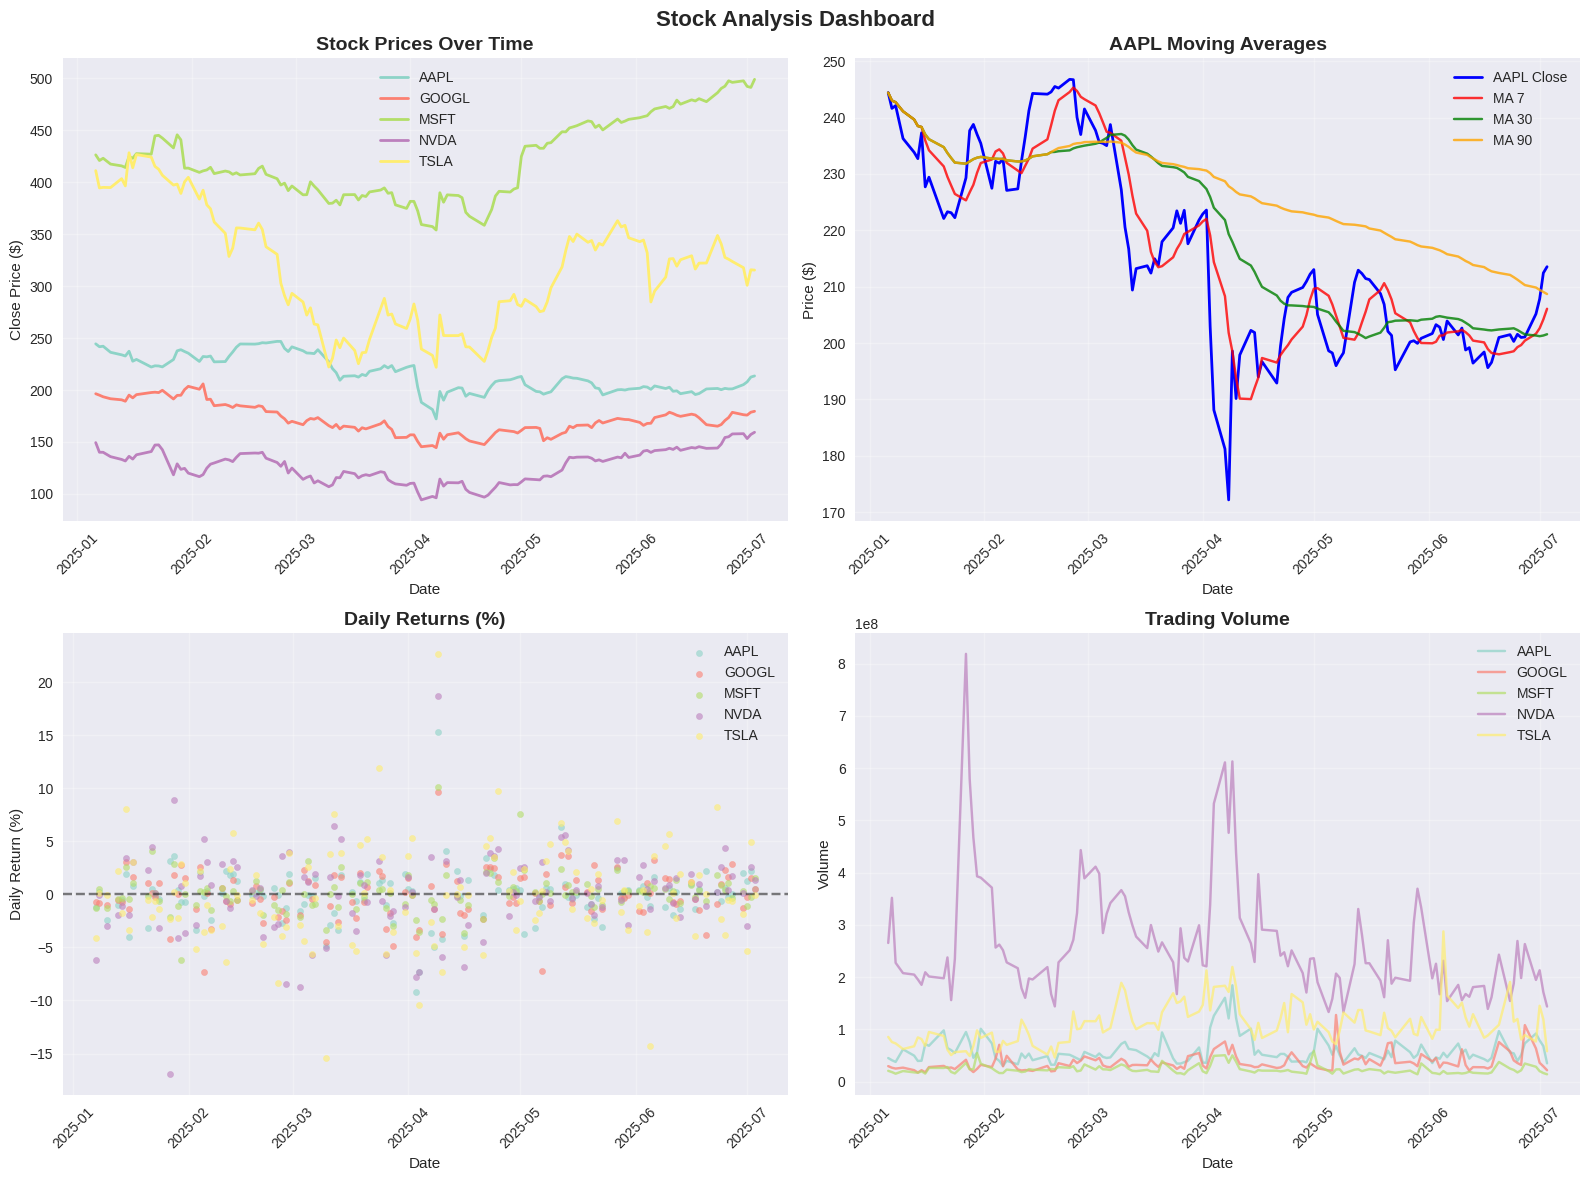

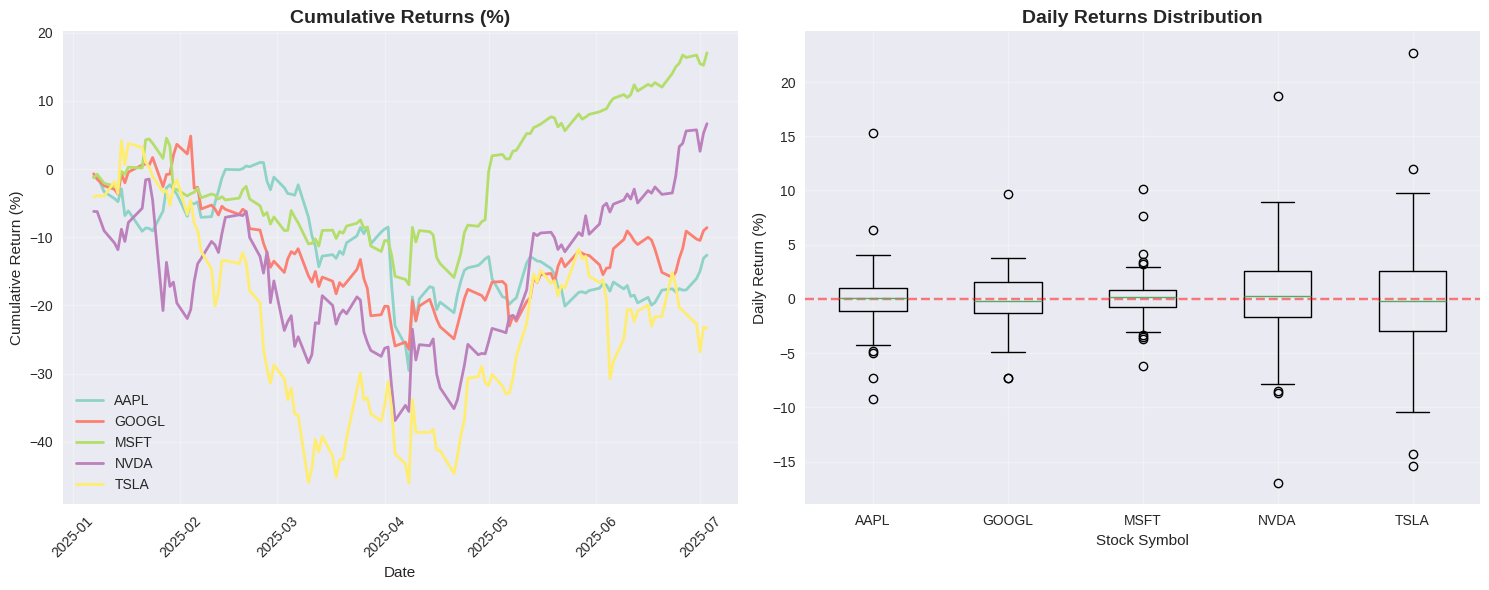

✅ ส่งออกข้อมูลเสร็จสิ้น: stock_analysis_result.csv

🎉 การวิเคราะห์เสร็จสิ้นเรียบร้อย!


In [ ]:
def main():
    """ฟังก์ชันหลักสำหรับทดสอบ ETL Pipeline"""

    # สร้าง ETL Pipeline
    etl = StockETLPipeline()

    # กำหนดหุ้นที่ต้องการวิเคราะห์
    symbols = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'TSLA']

    print("🎯 เริ่มต้น Stock ETL Pipeline Demo")
    print("=" * 60)

    # รัน Pipeline
    data = etl.run_pipeline(symbols, period="6mo")

    if data is not None:
        print("\n" + "=" * 60)
        print("📊 การวิเคราะห์ข้อมูล")
        print("=" * 60)

        # ข้อมูลล่าสุด
        latest = etl.get_latest_data()
        print("\n📈 ข้อมูลล่าสุด:")
        print(latest.to_string(index=False))

        # สรุปผลการดำเนินงาน
        performance = etl.get_performance_summary()
        print("\n🏆 สรุปผลการดำเนินงาน:")
        print(performance.to_string(index=False))

        # วิเคราะห์ Moving Average
        ma_analysis = etl.get_ma_analysis()
        recent_signals = ma_analysis.groupby('Symbol').first().reset_index()
        print("\n📊 สัญญาณ Moving Average ล่าสุด:")
        print(recent_signals[['Symbol', 'Date', 'Close', 'Signal', 'MA_Divergence_Pct']].to_string(index=False))

        # สร้างกราฟ
        print("\n📊 กำลังสร้างกราฟวิเคราะห์...")
        etl.create_visualizations()

        # ส่งออกข้อมูล
        etl.export_data('stock_analysis_result.csv')

        print("\n🎉 การวิเคราะห์เสร็จสิ้นเรียบร้อย!")

    else:
        print("❌ ไม่สามารถดำเนินการวิเคราะห์ได้")

if __name__ == "__main__":
    main()